In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import json
import shap

sns.set_theme(style="whitegrid")
print("Libraries loaded.")

Libraries loaded.


In [8]:
ROOT_DIR = '.'
FOLDER_IGNORE = ['.git', '.vscode']

# Searches for all folders (each folder is a IDS)
try:
    all_subdirs = [d.name for d in os.scandir(ROOT_DIR) if d.is_dir()]
    ids_project_folders = [
        d for d in all_subdirs
        if d not in FOLDER_IGNORE and os.path.exists(os.path.join(ROOT_DIR, d, 'src'))
    ]
except FileNotFoundError:
    print(f"ERROR: '{os.path.abspath(ROOT_DIR)}' not fiund.")
    ids_project_folders = []

if not ids_project_folders:
    print("No IDS projects found. Please check your folder structure.")
else:
    print("IDS projects found:")
    for folder in ids_project_folders:
        print(f"- {folder}")

IDS projects found:
- ocpp-ids


### analysis 1: comparative perfomance metrics

In [9]:
master_df_list = []

print("Searching for metric files...")
for ids_folder in ids_project_folders:
    print(f"\nProcessing project: {ids_folder}")
    results_path = os.path.join(ROOT_DIR, ids_folder, 'results')

    csv_files = glob.glob(os.path.join(results_path, '**', '*.csv'), recursive=True)

    if not csv_files:
        print(f"  -> No metric files found for {ids_folder}.")
        continue

    for f in csv_files:
        try:
            parts = f.split(os.sep)
            experiment_type = parts[-2]

            df = pd.read_csv(f)
            df['experiment_type'] = experiment_type
            df['ids_model'] = ids_folder
            master_df_list.append(df)
            print(f"  -> Loaded: {f}")
        except Exception as e:
            print(f"    WARNING: Failed to process {f}. Error: {e}")

if not master_df_list:
    print("\nNo metrics data was loaded. Analysis cannot continue.")
else:
    master_metrics_df = pd.concat(master_df_list, ignore_index=True)
    print(f"\nProcessing complete. Loaded a total of {len(master_metrics_df)} records.")
    print("Sample of the combined data:")
    display(master_metrics_df)

Searching for metric files...

Processing project: ocpp-ids
  -> Loaded: ./ocpp-ids/results/ocppflowmeter/modified_shap/modified_shap_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/ocppflowmeter/baseline/baseline_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/ocppflowmeter/modified_lime_shap/modified_lime_shap_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/ocppflowmeter/modified_lime/modified_lime_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/cicflowmeter/modified_shap/modified_shap_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/cicflowmeter/baseline/baseline_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/cicflowmeter/modified_lime_shap/modified_lime_shap_metrics_0.csv
  -> Loaded: ./ocpp-ids/results/cicflowmeter/modified_lime/modified_lime_metrics_0.csv

Processing complete. Loaded a total of 160 records.
Sample of the combined data:


,timestamp,client_id,dataset_name,round,xai_method_used,accuracy,TPR,FPR,f1_score,experiment_type,ids_model
0,2025-08-10 12:48:48,0,ocppflowmeter,1,both,0.997683,0.995656,0.004344,0.997682,modified_shap,ocpp-ids
1,2025-08-10 12:50:12,0,ocppflowmeter,2,both,1.000000,1.000000,0.000000,1.000000,modified_shap,ocpp-ids
2,2025-08-10 12:51:36,0,ocppflowmeter,3,both,0.998456,0.996139,0.003861,0.998453,modified_shap,ocpp-ids
3,2025-08-10 12:53:03,0,ocppflowmeter,4,both,0.999228,0.999517,0.000483,0.999228,modified_shap,ocpp-ids
4,2025-08-10 12:54:26,0,ocppflowmeter,5,both,1.000000,1.000000,0.000000,1.000000,modified_shap,ocpp-ids
...,...,...,...,...,...,...,...,...,...,...,...
155,2025-08-10 14:03:02,0,cicflowmeter,16,both,0.995472,0.991509,0.008491,0.995465,modified_lime,ocpp-ids
156,2025-08-10 14:04:25,0,cicflowmeter,17,both,0.993962,0.990566,0.009434,0.993962,modified_lime,ocpp-ids
157,2025-08-10 14:05:47,0,cicflowmeter,18,both,0.993962,0.990566,0.009434,0.993962,modified_lime,ocpp-ids
158,2025-08-10 14:07:09,0,cicflowmeter,19,both,0.995472,0.991509,0.008491,0.995465,modified_lime,ocpp-ids


In [21]:
sns.set_theme(style="whitegrid")

def plot_metric_by_dataset(df, metric_name, title_name, y_axis_label):
    unique_datasets = df['dataset_name'].unique()
    print(f"Datasets encontrados: {unique_datasets}. Gerando gráficos para a métrica '{metric_name}'.")

    for dataset in unique_datasets:
        print(f"--- Gerando gráfico para: {dataset} ---")
        
        df_filtered = df[df['dataset_name'] == dataset]
        
        g = sns.relplot(
            data=df_filtered,
            x='round',
            y=metric_name,
            hue='experiment_type',
            kind='line',
            marker='o',
            height=6,
            aspect=1.4
        )
        
        g.fig.suptitle(f'{title_name} para o Dataset: {dataset}', y=1.03, fontsize=16)
        g.set_axis_labels("Training Round", y_axis_label)
        
        if not df_filtered.empty:
            min_val = df_filtered[metric_name].min()
            max_val = df_filtered[metric_name].max()
            g.set(ylim=(min_val - (max_val * 0.001), max_val + (max_val * 0.001)))
            
        plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots')
        os.makedirs(plots_path, exist_ok=True)
        file_name = f'{metric_name.lower()}_{dataset}.png'
        plt.savefig(os.path.join(plots_path, file_name))
        print(f"Gráfico salvo como: {file_name}")
        
        plt.show()

Datasets encontrados: ['ocppflowmeter' 'cicflowmeter']. Gerando gráficos para a métrica 'accuracy'.
--- Gerando gráfico para: ocppflowmeter ---
Gráfico salvo como: accuracy_ocppflowmeter.png


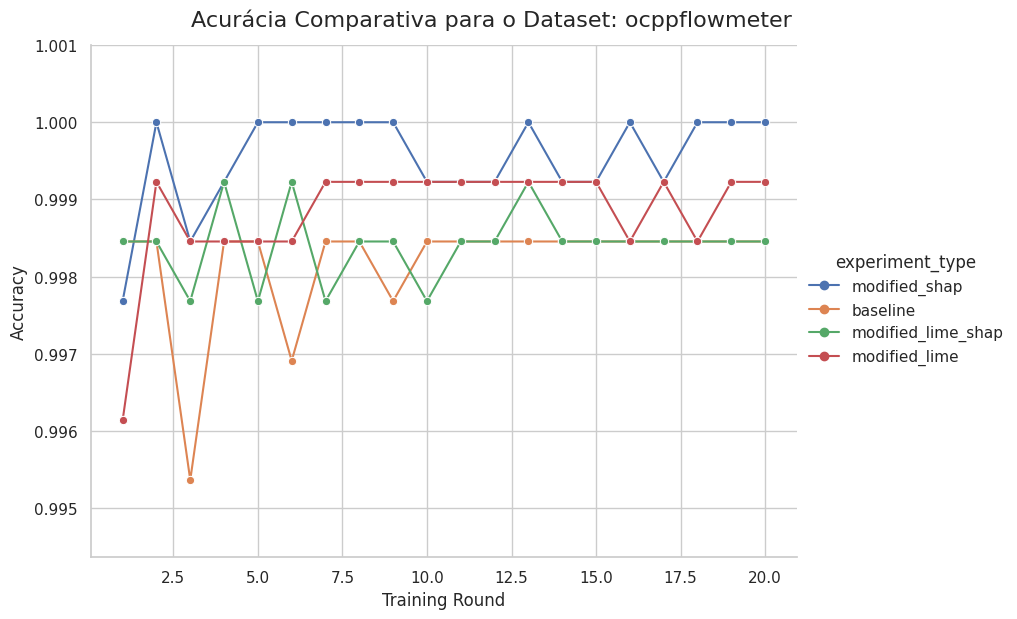

--- Gerando gráfico para: cicflowmeter ---
Gráfico salvo como: accuracy_cicflowmeter.png


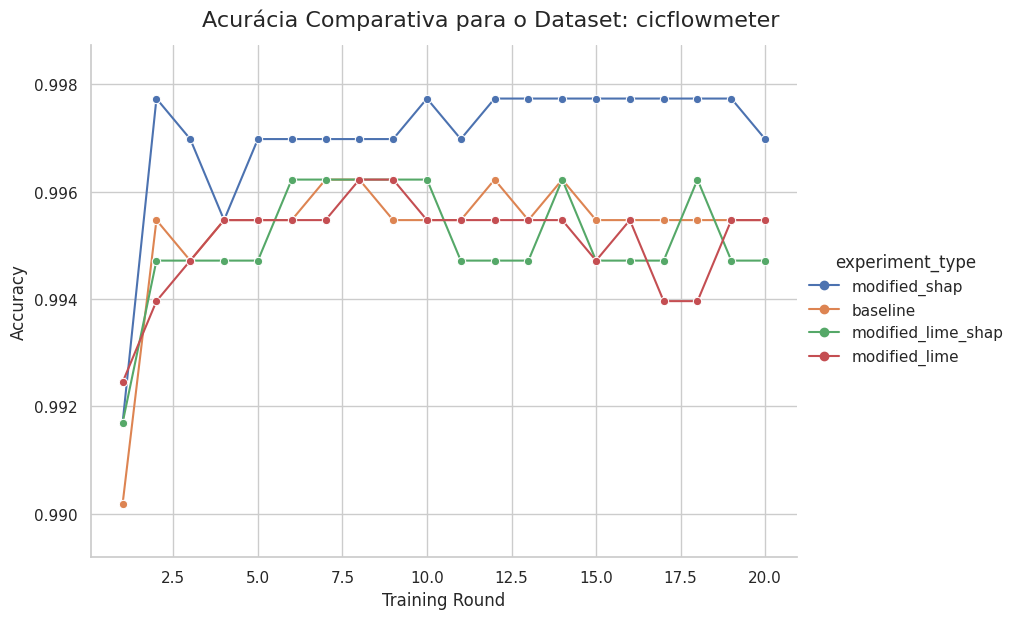

Datasets encontrados: ['ocppflowmeter' 'cicflowmeter']. Gerando gráficos para a métrica 'f1_score'.
--- Gerando gráfico para: ocppflowmeter ---
Gráfico salvo como: f1_score_ocppflowmeter.png


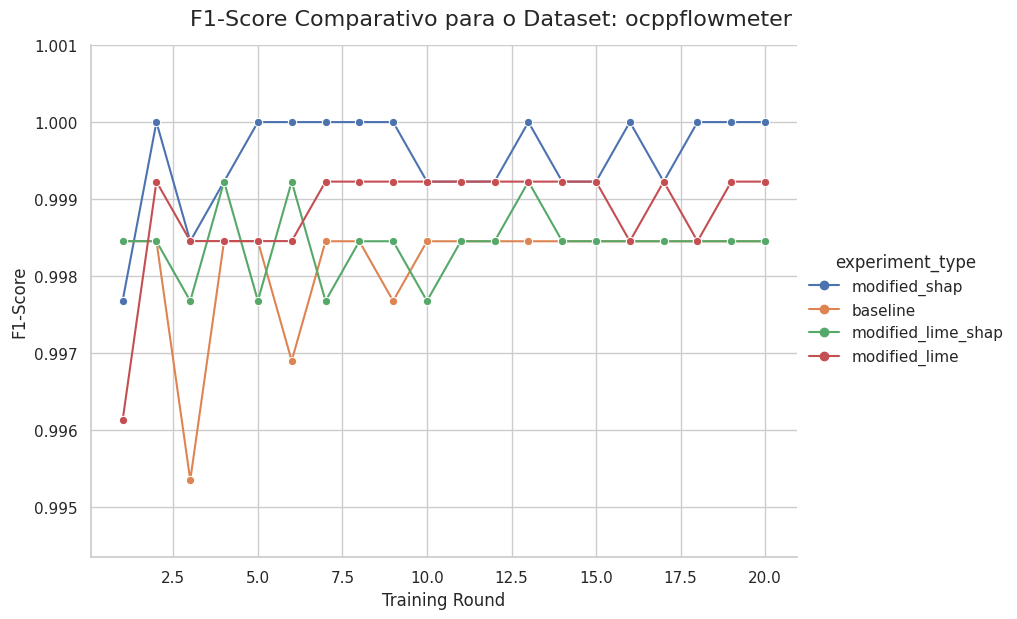

--- Gerando gráfico para: cicflowmeter ---
Gráfico salvo como: f1_score_cicflowmeter.png


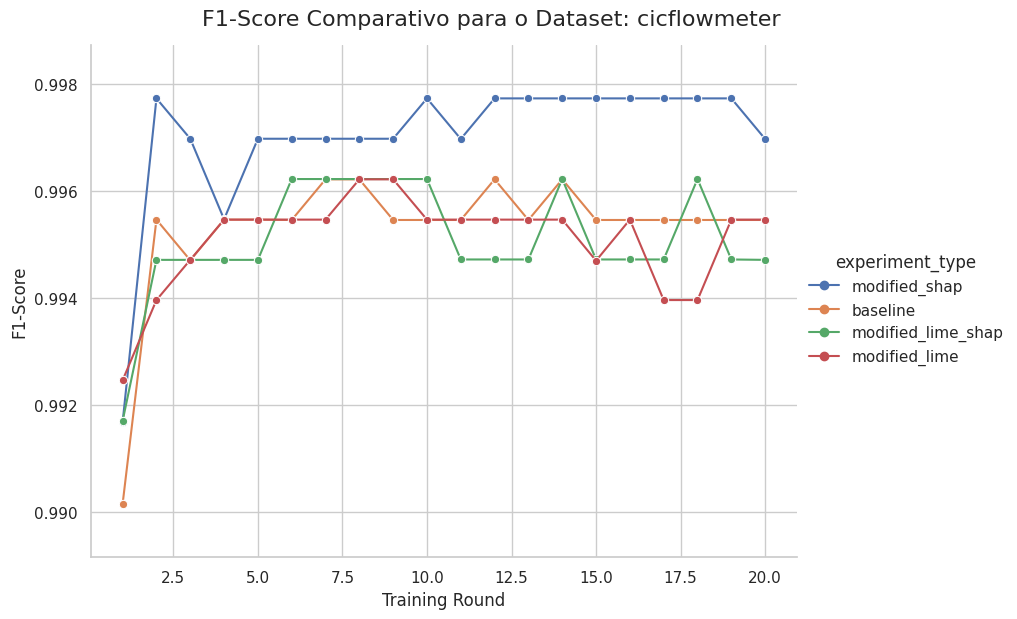

In [22]:
plot_metric_by_dataset(
    df=master_metrics_df, 
    metric_name='accuracy', 
    title_name='Acurácia Comparativa', 
    y_axis_label='Accuracy'
)

plot_metric_by_dataset(
    df=master_metrics_df, 
    metric_name='f1_score', 
    title_name='F1-Score Comparativo', 
    y_axis_label='F1-Score'
)

Gráfico de tempo de execução salvo como: execution_time_comparison.png


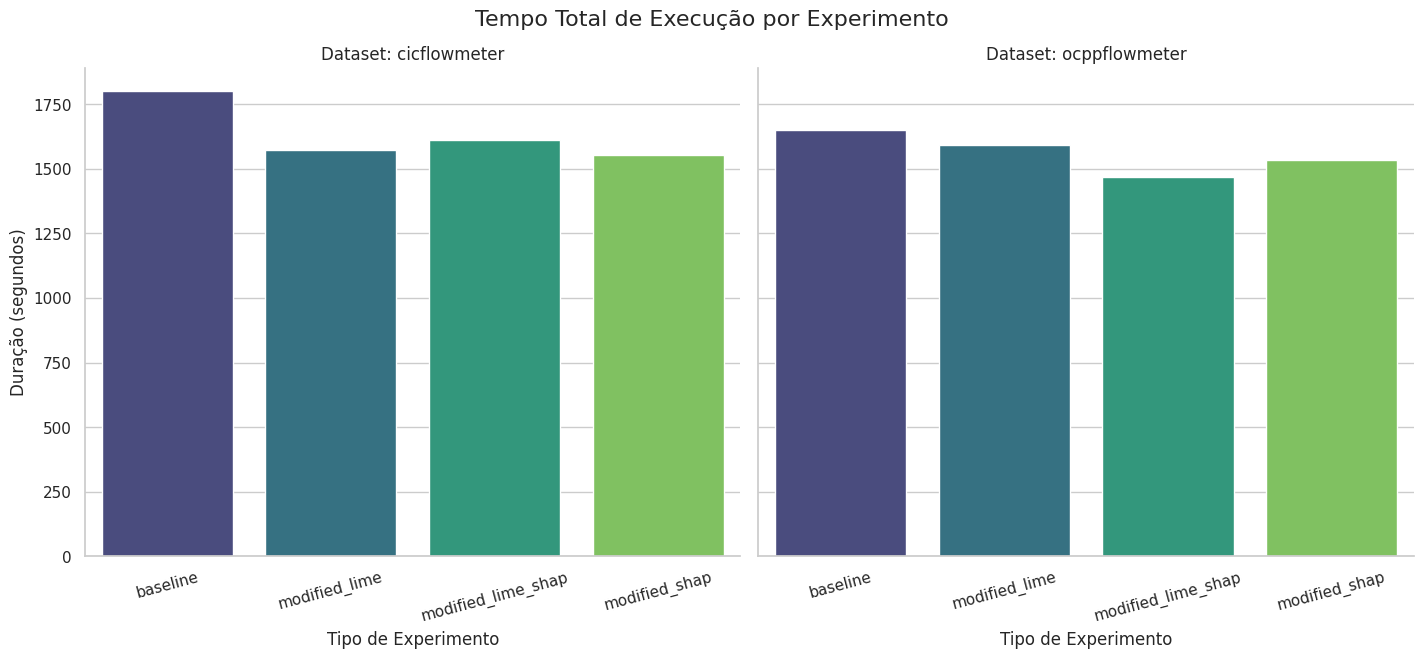

In [16]:
df_copy = master_metrics_df.copy()
df_copy['timestamp'] = pd.to_datetime(df_copy['timestamp'])

duration_df = df_copy.groupby(['dataset_name', 'experiment_type']).agg(
    start_time=('timestamp', 'min'),
    end_time=('timestamp', 'max')
).reset_index()

duration_df['duration_seconds'] = (duration_df['end_time'] - duration_df['start_time']).dt.total_seconds()

g = sns.catplot(
    data=duration_df,
    x='experiment_type',
    y='duration_seconds',
    col='dataset_name',
    kind='bar',
    height=6,
    aspect=1.2,
    palette='viridis',
    hue='experiment_type',
    legend=False
)

g.fig.suptitle('Tempo Total de Execução por Experimento', y=1.03, fontsize=16)
g.set_axis_labels("Tipo de Experimento", "Duração (segundos)")
g.set_titles("Dataset: {col_name}")
g.set_xticklabels(rotation=15)

plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots')
os.makedirs(plots_path, exist_ok=True)
file_name = 'execution_time_comparison.png'
plt.savefig(os.path.join(plots_path, file_name))
print(f"Gráfico de tempo de execução salvo como: {file_name}")

plt.show()

### analysis 2: feature importance with shap

Generating SHAP plots for all projects...

--- Project: ocpp-ids ---
  -> Generating plot for Exp: baseline, Client: 0


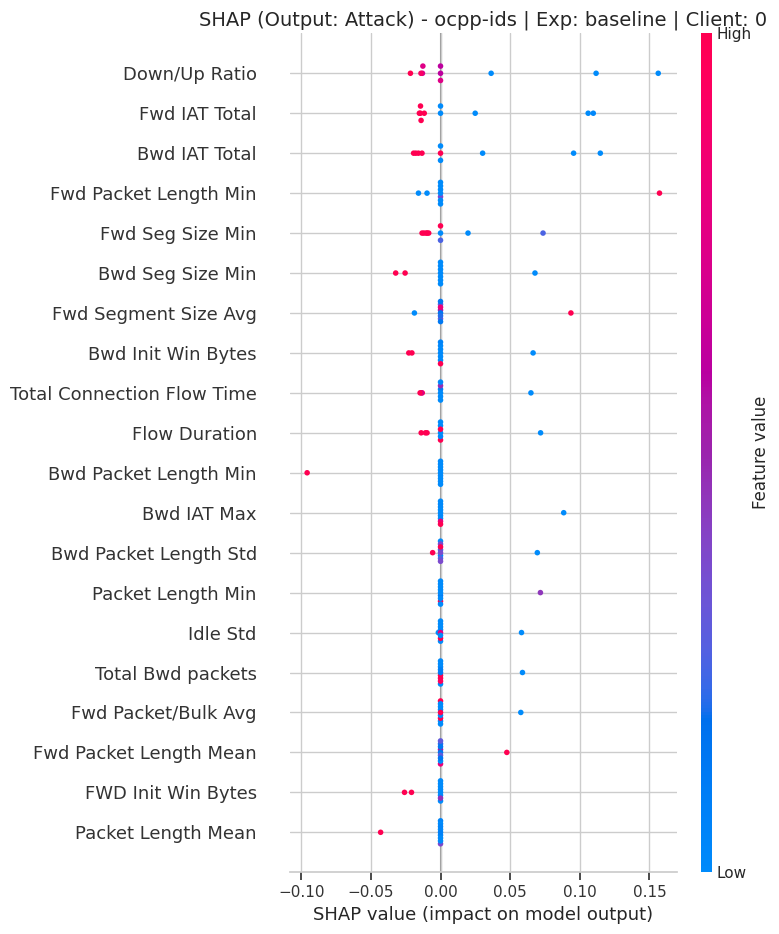

  -> Generating plot for Exp: modified_lime, Client: 0


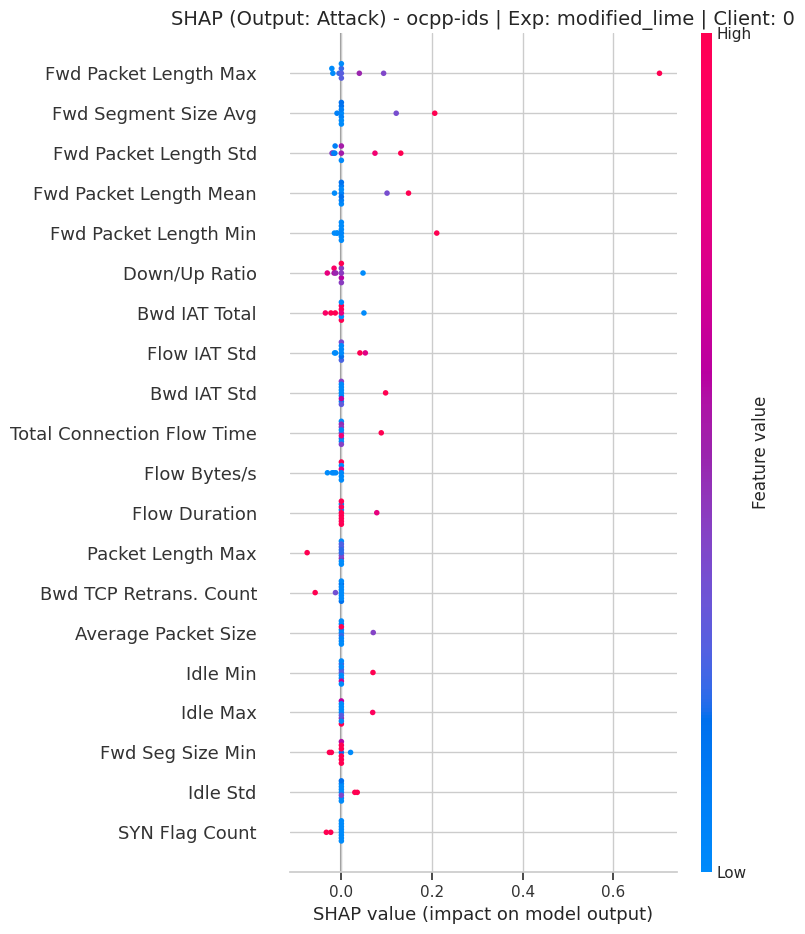

  -> Generating plot for Exp: modified_lime_shap, Client: 0


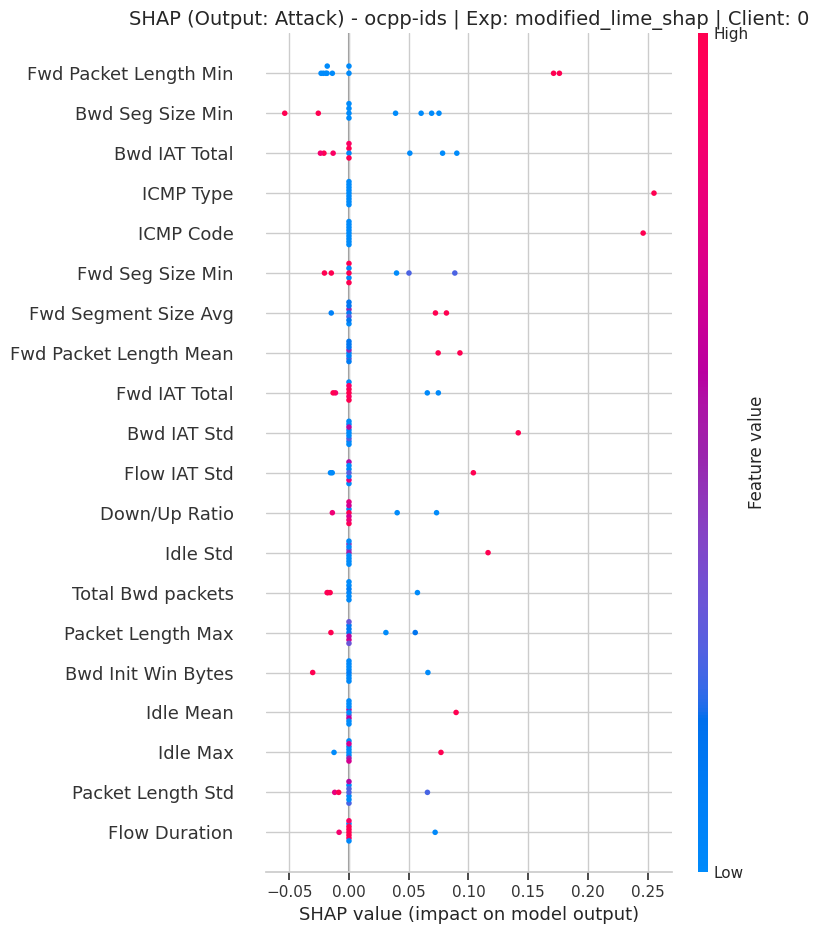

  -> Generating plot for Exp: modified_shap, Client: 0


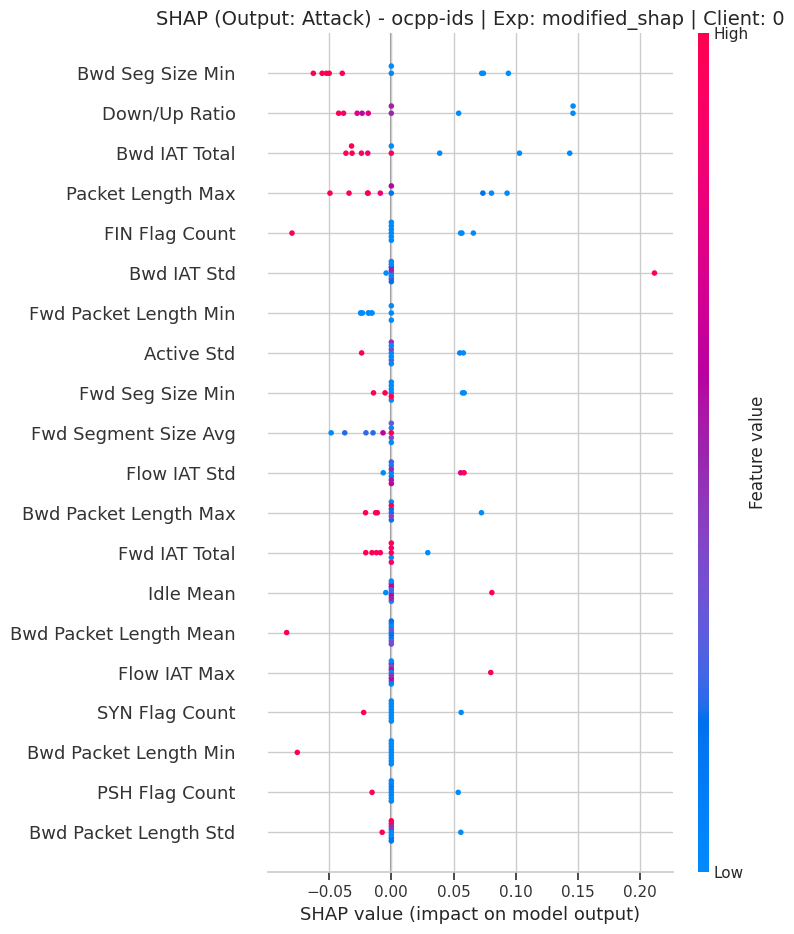

  -> Generating plot for Exp: baseline, Client: 0


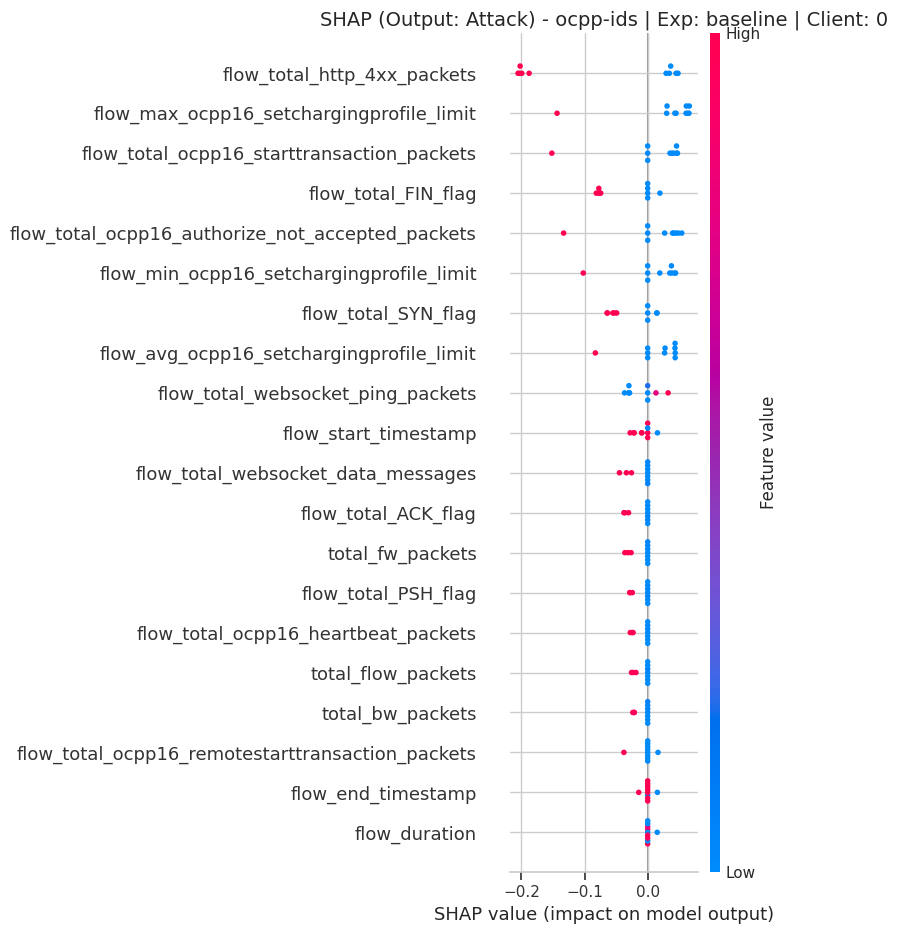

  -> Generating plot for Exp: modified_lime, Client: 0


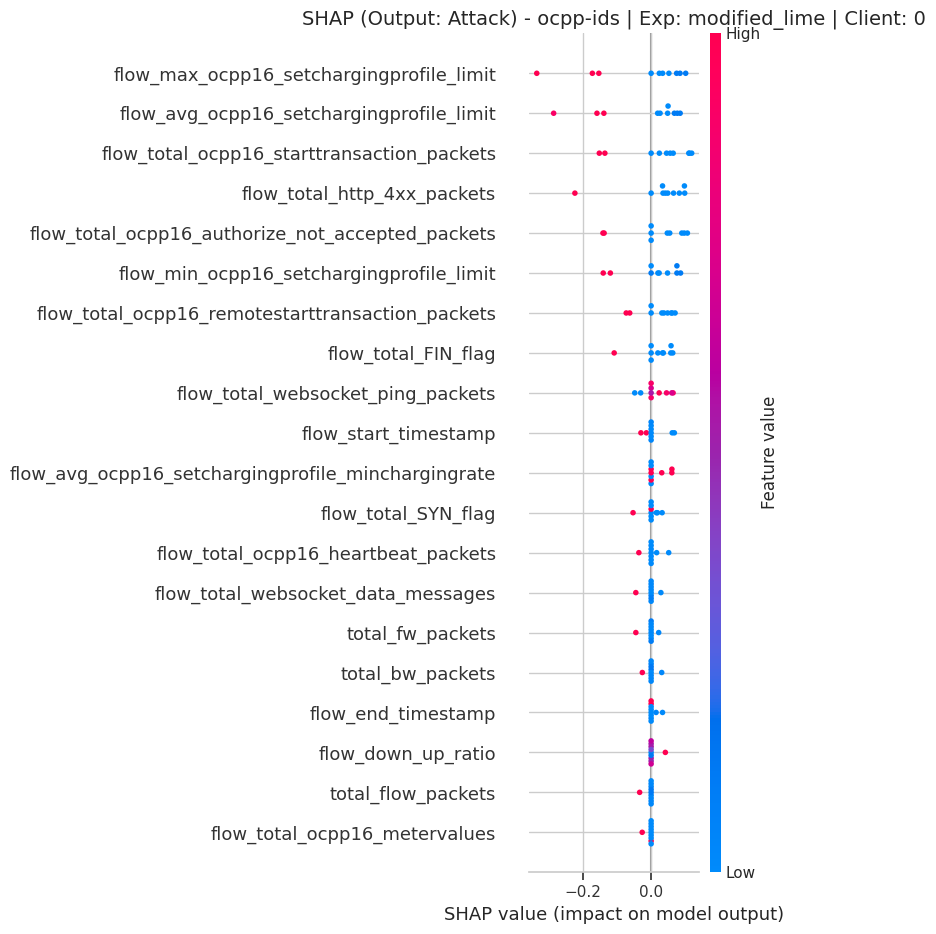

  -> Generating plot for Exp: modified_lime_shap, Client: 0


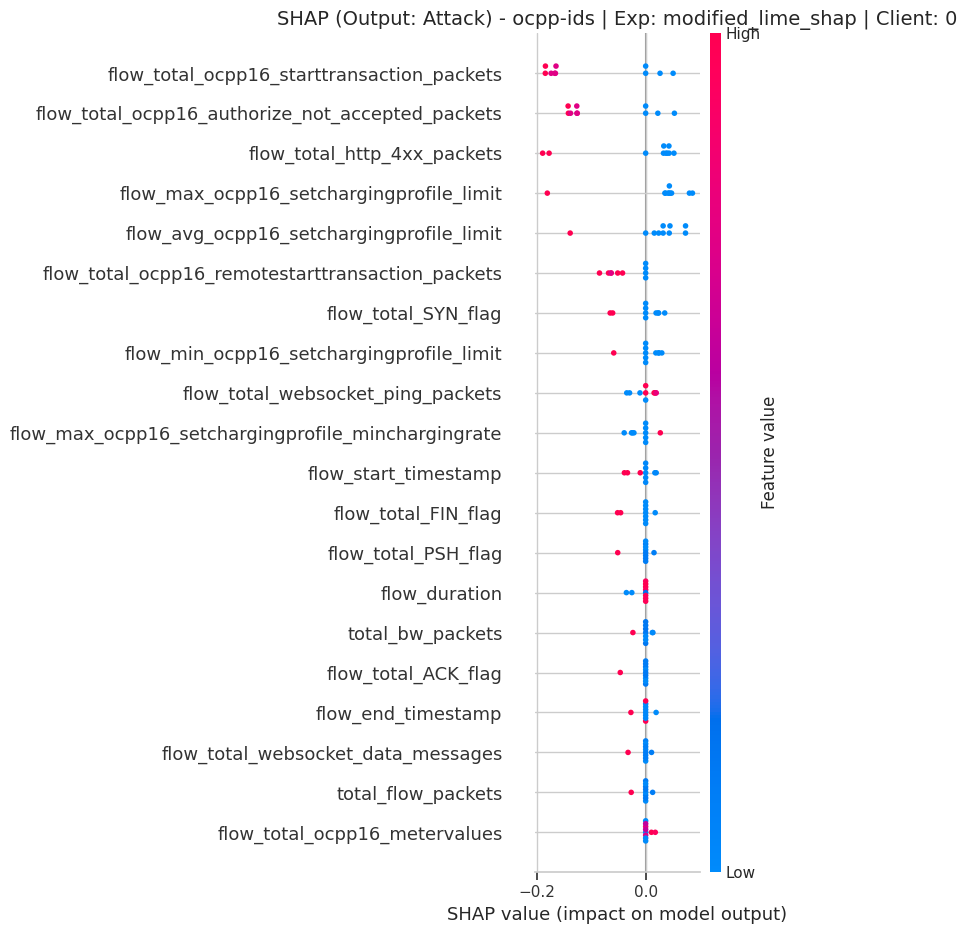

  -> Generating plot for Exp: modified_shap, Client: 0


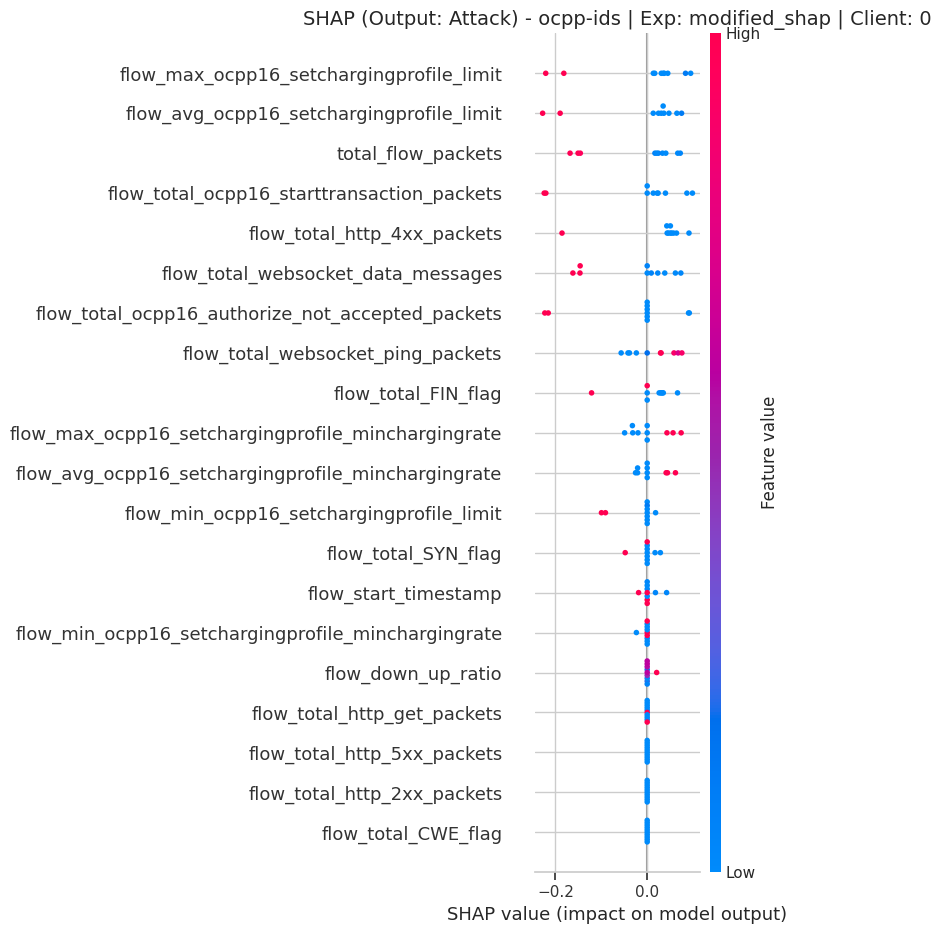

In [11]:
print("Generating SHAP plots for all projects...")
for ids_folder in ids_project_folders:
    print(f"\n--- Project: {ids_folder} ---")
    results_path = os.path.join(ROOT_DIR, ids_folder, 'results')
    
    shap_files = sorted(glob.glob(os.path.join(results_path, '**', 'shap_values_*.npy'), recursive=True))

    if not shap_files:
        print("  -> No SHAP files found.")
        continue

    for shap_file in shap_files:
        try:
            # ... (código para carregar os arquivos continua o mesmo) ...
            parts = shap_file.split(os.sep)
            experiment_type = parts[-3]
            client_number = parts[-1].split('_')[-1].split('.')[0]
            
            shap_dir = os.path.dirname(shap_file)
            data_file = os.path.join(shap_dir, f'shap_data_client_{client_number}.npy')
            features_file = os.path.join(shap_dir, f'shap_features_client_{client_number}.json')

            shap_values = np.load(shap_file, allow_pickle=True)
            data_samples = np.load(data_file, allow_pickle=True)
            with open(features_file, 'r') as f:
                feature_names = json.load(f)

            print(f"  -> Generating plot for Exp: {experiment_type}, Client: {client_number}")
            
            # --- CORREÇÃO APLICADA AQUI PARA MODELO BINÁRIO ---
            # O array shap_values pode ter a forma (amostras, features, 1) ou (amostras, features).
            # Se for 3D, removemos a última dimensão que é de tamanho 1.
            if shap_values.ndim == 3 and shap_values.shape[2] == 1:
                shap_values_to_plot = shap_values[:, :, 0]
            else:
                shap_values_to_plot = shap_values
            
            shap.summary_plot(shap_values_to_plot, data_samples, feature_names=feature_names, show=False)
            
            # O título agora reflete a explicação para a classe 'Attack'
            plt.title(f'SHAP (Output: Attack) - {ids_folder} | Exp: {experiment_type} | Client: {client_number}', fontsize=14)
            plt.tight_layout()
            
            plots_path = os.path.join(ROOT_DIR, 'notebooks', 'plots', ids_folder)
            os.makedirs(plots_path, exist_ok=True)
            plt.savefig(os.path.join(plots_path, f'shap_{experiment_type}_client_{client_number}_binary.png'))
            plt.show()
        except Exception as e:
            print(f"    WARNING: Failed to process {shap_file}. Error: {e}")

### analysis 3: quantitative analysis with LIME

The analysis of LIME results is a manual and qualitative process, done by opening the generated HTML files. You can now compare explanations not only between experiments (`baseline` vs. `modified`) but also between the different IDS models to understand if they "reason" in fundamentally different ways.

**Analysis Workflow:**
1.  Open the HTML reports from `OCPP-IDS/results/baseline/lime/`.
2.  Open the HTML reports from `Another_IDS/results/baseline/lime/`.
3.  Compare them. For the same type of attack (if applicable), do the two IDS models use the same features to justify their decisions? This analysis can reveal much about the nature of each model.